In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image



sys.path.insert(0, './lib/')
from MovingMNIST import MovingMNIST

In [46]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

transform = transforms.Compose([transforms.Normalize((0), (255))])
# transform = None

train_set = MovingMNIST.MovingMNIST(root='.data/mnist', train=True, download=True, transform=transform)
test_set = MovingMNIST.MovingMNIST(root='.data/mnist', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

for seq, seq_target in train_loader:
    print('--- Sample')
    print('Input:  ', seq.shape)
    print('Target: ', seq_target.shape)
    break

==>>> total trainning batch number: 90
==>>> total testing batch number: 10
--- Sample
Input:   torch.Size([100, 10, 64, 64])
Target:  torch.Size([100, 10, 64, 64])


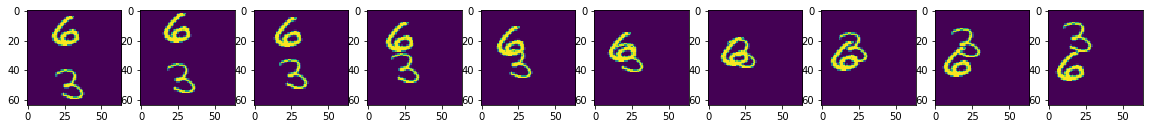

In [47]:
seq, seq_target = next(iter(train_loader))
fig=plt.figure(figsize=(20, 8))

for i in range(1, 11):
    img = seq[0][i-1]
    fig.add_subplot(1, 10, i)
    plt.imshow(img)

In [48]:
import numpy as np
print(np.max(np.array(seq[0][0])))
print(seq[0][0][20])

1.0
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3569,
        0.9765, 0.9922, 0.9922, 0.9922, 0.8275, 0.9922, 0.9922, 0.9922, 0.6863,
        0.8471, 0.6824, 0.6824, 0.9294, 0.9922, 0.9922, 0.8941, 0.5137, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [49]:
# Writing our model

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(10, 5, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(5,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,5,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(5,10,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#defining some params
num_epochs = 25 #you can go for more epochs, I am using a mac

model = Autoencoder()
model.cuda()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

for epoch in range(num_epochs):
    for step, data in enumerate(train_loader):
        seq, target = data
        seq = seq.cuda()
        target = target.cuda()
        seq = Variable(seq)
        # ===================forward=====================
        output = model(seq)
        loss = distance(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, float(loss.data)))



epoch [1/25], loss:0.0356
epoch [2/25], loss:0.0347
epoch [3/25], loss:0.0352
epoch [4/25], loss:0.0333
epoch [5/25], loss:0.0341
epoch [6/25], loss:0.0336
epoch [7/25], loss:0.0348


In [ ]:
seq, seq_target = next(iter(train_loader))

fig=plt.figure(figsize=(20, 8))

for i in range(1, 11):
    img = seq_target[0][i-1]
    fig.add_subplot(1, 10, i)
    plt.imshow(img)


output = model(seq.cuda())
fig=plt.figure(figsize=(20, 8))

for i in range(1, 11):
    img = output[0][i-1].cpu().detach().numpy()
    fig.add_subplot(1, 10, i)
    plt.imshow(img)
